In [132]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt

# change directory to the 
os.chdir(r"C:\Users\dougj\Documents\Data\DHS\India\IAIR74DT")

In [33]:
# check the first instance of the variable v000 to determine which DHS round this was (and thus was recode manual to use)
chunk_iter = pd.read_stata("IAIR74FL.dta", columns = ['v000'], chunksize = 1000)
temp = next(chunk_iter)
temp['v000'][0] # Note that they use the 6th round questionnaire even though the survey was part of the 7th round of the contract

'IA6'

# Variables to import
The "individual" section of the DHS 7 recode manual includes more information a
The list of variables that I need are...
* v155 - variable for whether or not the respondent can read the sentence
* v005 - weight
* v012 - age
* v021 - PSU
* v101 - region
* v102 - rural / urban
* v022 - first stage strata (groupings of PSUs)
* v023 - another strata var, unclear what this is though
* v106 - highest education level acheived
* v107 - highest year of education in grade (don't use this one)
* v133 - education in single years (use this one)


Other variables to look at later:
* Child mortality
* Child health
* Asset ownership
* mv155 from men's dataset (which seems to be the same question for men)
* hv122 and up -- variables for school attendance in the hh roster (in hh dataset)



In [34]:
# define which columns we want to import. (this really speeds up the import process)
cols2import = ['v155', 'v005', 'v012', 'v021', 'v101', 'v102', 'v022', 'v023', 'v106', 'v107', 'v133']
df = pd.read_stata("IAIR74FL.dta", columns = cols2import)

In [40]:
# check that region = state
df['v101'].value_counts()

uttar pradesh                  97661
madhya pradesh                 62803
bihar                          45812
rajasthan                      41965
odisha                         33721
maharashtra                    29460
jharkhand                      29046
tamil nadu                     28820
assam                          28447
karnataka                      26291
chhattisgarh                   25172
jammu and kashmir              23800
gujarat                        22932
haryana                        21654
punjab                         19484
west bengal                    17668
uttarakhand                    17300
arunachal pradesh              14294
manipur                        13593
mizoram                        12279
kerala                         11033
nagaland                       10790
andhra pradesh                 10428
himachal pradesh                9929
meghalaya                       9202
telangana                       7567
delhi                           5914
s

In [43]:
# check whether respondent is ever marked illiterate if she completed primary school
print(df['v106'].value_counts())
pd.crosstab(df['v106'], df['v155']) # all women who have done any secondary or higher marked as "able to read"

secondary       334927
no education    196556
primary          88290
higher           79913
Name: v106, dtype: int64


v155,cannot read at all,able to read only parts of sentence,able to read whole sentence,no card with required language,blind/visually impaired
v106,,,,,
no education,184818,5870,2447,560,2861
primary,35127,33913,18061,588,601
secondary,0,0,334927,0,0
higher,0,0,79913,0,0


In [46]:
# crosstab the two education variables to understand how they interact.  
# it looks like we should first drop all women for whom v106 is secondary or higher and then use v133 (or may v107 will be the same)
pd.crosstab(df['v107'], df['v106'], margins = True, dropna = False)

v106,no education,primary,secondary,higher,All
v107,,,,,
no years completed at level v106,0,1012,0,0,1012
1.0,0,2376,17341,10582,30299
2.0,0,9000,33219,9633,51852
3.0,0,11603,62651,37386,111640
4.0,0,16947,64753,4935,86635
5.0,0,47352,72156,13974,133482
6.0,0,0,23730,2383,26113
7.0,0,0,61077,670,61747
8.0,0,0,0,350,350


In [48]:
df['v106'].value_counts()

secondary       334927
no education    196556
primary          88290
higher           79913
Name: v106, dtype: int64

In [122]:
# create variable for primary or less
df['prim_grad'] = np.where((df['v106']=="secondary") | (df['v106']=="higher"), 1,0)
print(df['no_second'].value_counts())

# create variable for completely illiterate
df['illiterate'] = np.where(df['v155']=="cannot read at all",1 ,0)
df['illiterate'].value_counts()

0    414840
1    284846
Name: no_second, dtype: int64


0    479741
1    219945
Name: illiterate, dtype: int64

In [123]:
# check that all women who have 0 for this var are recorded as literate
pd.crosstab(df['prim_grad'],df['v155'], normalize = 'index', margins = True, dropna = False) # this check works

v155,cannot read at all,able to read only parts of sentence,able to read whole sentence,no card with required language,blind/visually impaired
prim_grad,,,,,
0,0.772154,0.139665,0.071997,0.004030,0.012154
1,0.000000,0.000000,1.000000,0.000000,0.000000
All,0.314348,0.056858,0.622205,0.001641,0.004948


In [125]:
# inspect the proportion of women who finish primary by state
pd.crosstab(df['v101'], df['prim_grad'], normalize = 'index', margins = True, dropna = False)

prim_grad,0,1
v101,,
andaman and nicobar islands,0.226610,0.773390
andhra pradesh,0.476985,0.523015
arunachal pradesh,0.451868,0.548132
assam,0.366963,0.633037
bihar,0.572667,0.427333
chandigarh,0.222520,0.777480
chhattisgarh,0.451692,0.548308
dadra and nagar haveli,0.415829,0.584171
daman and diu,0.234027,0.765973


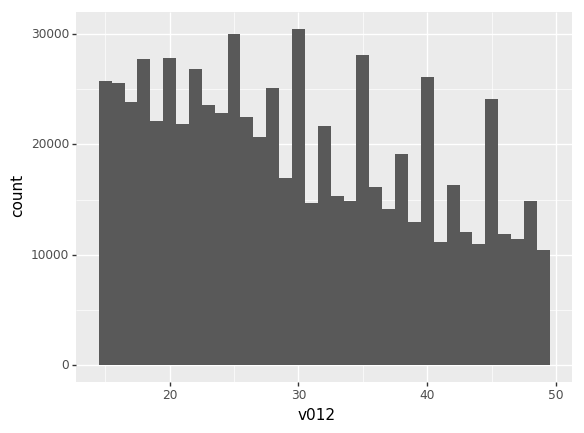

<ggplot: (149802117836)>

In [126]:
# histogram of age
from plotnine import *
(ggplot(df, aes(x = 'v012'))+geom_histogram(binwidth =1))

# look at primary completion rates by age
# couldn't figure out how to do this in plotnine

In [131]:
# among women who haven't completed primary, compare literacy across states
df2 = df[df['prim_grad']==0]
df2.shape
df3 =pd.crosstab(df2['v101'],df2['illiterate'], normalize = 'index')

illiterate,0,1
v101,,
andaman and nicobar islands,0.328100,0.671900
andhra pradesh,0.221753,0.778247
arunachal pradesh,0.211797,0.788203
assam,0.233164,0.766836
bihar,0.160206,0.839794
chandigarh,0.283133,0.716867
chhattisgarh,0.224714,0.775286
dadra and nagar haveli,0.093656,0.906344
daman and diu,0.273006,0.726994


### 

# Key takeaways
* Primary completion rates vary a lot by state -- from ~46% in Rajasthan to 76% in HP
* Literacy rates vary a lot as well, but in unexpected ways